<a href="https://colab.research.google.com/github/gmshroff/metaLearning2022/blob/main/code/nb3_CNP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MODEL-BASED META-LEARNING USING 

# Conditional Neural Processes

In [1]:
# !pip install import_ipynb --quiet

In [2]:
# !pip install learn2learn --quiet

In [3]:
# import requests

In [4]:
# r=requests.get("https://github.com/gmshroff/metaLearning2022/blob/main/code/utils.ipynb?raw=true")
# with open('./utils.ipynb','wb') as f: f.write(r.content)

In [5]:
# r=requests.get("https://github.com/gmshroff/metaLearning2022/blob/main/code/l2lutils.ipynb?raw=true")
# with open('./l2lutils.ipynb','wb') as f: f.write(r.content)

In [2]:
import import_ipynb
import utils

importing Jupyter notebook from utils.ipynb


In [3]:
from IPython import display
import torch
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from l2lutils import KShotLoader
from IPython import display

importing Jupyter notebook from l2lutils.ipynb


This CNP is the class you need to write for HW2

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %ls drive/MyDrive/'Colab Notebooks'

In [2]:
# !cp drive/MyDrive/'Colab Notebooks'/models.ipynb .
# !cp drive/MyDrive/'Colab Notebooks'/CNP.ipynb .

In [3]:
from CNP import CNP

importing Jupyter notebook from models.ipynb


In [4]:
import models

# Data Generation/Loading

In [4]:
#Generate data - euclidean
meta_train_ds, meta_test_ds, full_loader = utils.euclideanDataset(n_samples=10000,n_features=20,n_classes=10,batch_size=32)

In [8]:
meta_train_ds[0]

(tensor([ 3.9403, -0.1496,  3.0716, -3.9488,  6.1080, -1.1698,  1.1856,  3.3844,
         -2.3111,  4.4123,  3.1820,  1.9553,  1.8277,  0.8133, -1.0793, -5.5694,
          2.0955,  1.7963,  2.0716,  0.1909]),
 tensor(8))

In [14]:
# Define an MLP network. Note that input dimension has to be data dimension. For classification
# final dimension has to be number of classes; for regression one.
#torch.manual_seed(10)
net = models.MLP(dims=[20,64,10])

In [15]:
# Train the network; note that network is trained in place so repeated calls further train it.
net,losses,accs=models.Train(net,full_loader,lr=1e-2,epochs=20,verbose=True)

Epoch   19 Loss: 9.11859e-02 Accuracy: 0.98604


In [16]:
#Training accuracy.
models.accuracy(net,meta_train_ds.samples,meta_train_ds.labels,verbose=True)

7404.0 7500


0.9872

In [17]:
# Test accuracy.
models.accuracy(net,meta_test_ds.samples,meta_test_ds.labels)

2423.0 2500


0.9692

# Meta-Learning: Tasks

Generate a k-shot n-way loader using the meta-training dataset

In [20]:
meta_train_kloader=KShotLoader(meta_train_ds,shots=5,ways=2)

Sample a task - each task has a k-shot n-way training set and a similar test set

In [21]:
d_train,d_test=meta_train_kloader.get_task()

Let's try directly learning using the task training set albeit its small size: create a dataset and loader and train it with the earlier network and Train function.

In [22]:
taskds = utils.MyDS(d_train[0],d_train[1])

In [26]:
d_train_loader = torch.utils.data.DataLoader(dataset=taskds,batch_size=1,shuffle=True)

In [33]:
net,losses,accs=models.Train(net,d_train_loader,lr=1e-1,epochs=10,verbose=True)

Epoch   9 Loss: 1.73930e-04 Accuracy: 1.00000


How does it do on the test set of the sampled task?

In [34]:
models.accuracy(net, d_test[0], d_test[1])

9.0 10


0.9

# CNP-based  Meta-learning

In [6]:
# optimisers from torch
import torch.optim as optim
import torch.nn.functional as F

In [36]:
lossfn = torch.nn.NLLLoss()

Get a task dataset.

In [37]:
meta_train_kloader=KShotLoader(meta_train_ds,shots=5,ways=2,num_tasks=1000)

In [38]:
d_train,d_test = meta_train_kloader.get_task()

In [128]:
from CNP import CNP
net = CNP(n_features=20, dims=[32, 64, 32], n_ways=5, n_classes=2)

In [ ]:
print(net.mlp1, net.mlp2)

In [ ]:
torch.eye(2)[d_train[1]] 

In [129]:
# r,m,R = net.adapt(d_train[0],d_train[1])
# r.shape,m.shape,R.shape

r = net.adapt(d_train[0], d_train[1])
r.shape

torch.Size([64])

In [ ]:
m

In [132]:
net(d_test[0], r)

tensor([[-0.6583, -0.7293],
        [-0.7052, -0.6813],
        [-0.6663, -0.7207],
        [-0.7328, -0.6550],
        [-0.6324, -0.7578],
        [-0.6304, -0.7601],
        [-0.7175, -0.6694],
        [-0.7031, -0.6833],
        [-0.6581, -0.7294],
        [-0.7353, -0.6527]], grad_fn=<LogSoftmaxBackward0>)

# Putting it all together: CNP-based Meta-learning
Now let's put it together in a loop - CNP model-based meta-learning algorithm:

In [7]:
# Redifning accuracy function so that it takes h - dataset context - as input since net requires it.
def accuracy(Net,X_test,y_test,h,verbose=True):
    #Net.eval()
    m = X_test.shape[0]
    y_pred = Net(X_test,h)
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_test).float().sum().item()
    if verbose: print(correct,m)
    accuracy = correct/m
    #Net.train()
    return accuracy

In [63]:
classes_train = [i for i in range(5)]
classes_test = [i+3 for i in range(5)]
classes_train, classes_test

([0, 1, 2, 3, 4], [3, 4, 5, 6, 7])

In [64]:
import learn2learn as l2l
import torch.optim as optim

from CNP import CNP

shots,ways = 5,2
net = CNP(n_features=20,n_classes=ways,dims=[32,64,32],lr=1e-4,n_ways=5)
lossfn = torch.nn.NLLLoss()
meta_train_kloader=KShotLoader(meta_train_ds,shots=shots,ways=ways,num_tasks=1000, classes=classes_train)

In [65]:
#Meta-testing task loader for later.
meta_test_kloader=KShotLoader(meta_test_ds,shots=shots,ways=ways, classes=classes_test)

In [66]:
loss_list = []
acc_list  = []

In [69]:
epoch=0
n_epochs=100
task_count=50
while epoch<n_epochs:
    test_loss = 0.0
    test_acc = 0.0
    # Sample and train on a task
    for task in range(task_count):
        d_train,d_test=meta_train_kloader.get_task()
        rp = torch.randperm(d_train[1].shape[0])
        d_train0=d_train[0][rp]
        d_train1=d_train[1][rp]
        x_tr = d_train0
        d_tr = x_tr 
        h = net.adapt(d_tr,d_train1)
        rp1 = torch.randperm(d_test[1].shape[0])
        d_test0=d_test[0][rp1]
        d_test1=d_test[1][rp1]
        x_ts = d_test0
        y_ts_sh = torch.zeros(x_ts.shape[0],ways)
        d_ts = x_ts 
        test_preds = net(d_ts,h)
        #train_preds = net(d_tr,h)
        # Accumulate losses over tasks - note train and test loss both included
        test_loss += lossfn(test_preds,d_test1)#+lossfn(train_preds,d_train1)
        net.eval()
        test_acc += accuracy(net,d_ts,d_test1,h,verbose=False)
        net.train()
    #Update the network weights
    print('Epoch  % 2d Loss: %2.5e Avg Acc: %2.5f'%(epoch,test_loss/task_count,test_acc/task_count))

    loss_list.append(test_loss/task_count)
    acc_list.append(test_acc/task_count)
    display.clear_output(wait=True)
    net.optimizer.zero_grad()
    test_loss.backward()
    net.optimizer.step()
    epoch+=1
    

Epoch   99 Loss: 4.10933e-01 Avg Acc: 0.87400


Now test the trained CNP network and to tasks sampled from the meta_test_ds dataset:

In [70]:
meta_test_kloader=KShotLoader(meta_test_ds,shots=shots,ways=ways, classes=classes_test)
test_acc = 0.0
task_count = 50
adapt_steps = 1
# Sample and train on a task
for task in range(task_count):
    d_train,d_test=meta_test_kloader.get_task()
    x_tr = d_train[0]
    y_tr_sh = torch.cat((torch.zeros(1,ways),torch.eye(ways)[d_train[1][1:]]))
    d_tr = x_tr #torch.cat((x_tr,y_tr_sh),1)
    h=net.adapt(d_tr,d_train[1])
    x_ts = d_test[0]
    y_ts_sh = torch.zeros(x_ts.shape[0],ways)
    d_ts = x_ts #torch.cat((x_ts,y_ts_sh),1)
    test_preds = net(d_ts,h)
    test_acc += accuracy(net,d_ts,d_test[1],h,verbose=False)
    # Done with a task
net.train()
print('Avg Acc: %2.5f'%(test_acc/task_count))

Avg Acc: 0.63600


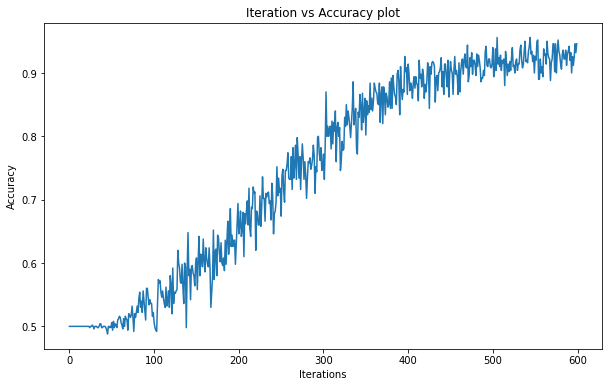

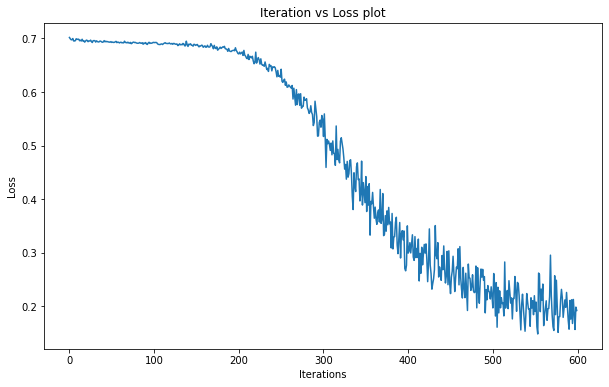

In [15]:
# plotting accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(acc_list)
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Iteration vs Accuracy plot")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(loss_list)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Iteration vs Loss plot")
plt.show()